## Customer segmentation

### Import modules requiered

First of all, we need to import the required module. 

In [1]:
%load_ext autoreload

In [2]:
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley, color="#c7e9c0", edgecolor="#006d2c", alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='#253494',alpha=0.5,lw=2) 
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color="#000000", ha="center", va="center")
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color="#000000", ha="center", va="center")
    plt.xlim(-.75,1)
    plt.ylim(-0.5,1)
    plt.grid(False)
    plt.xticks(np.arange(0, 1, 0.5), size=12)
    plt.yticks(np.arange(-0.75, 1, 0.5), size=12)
    plt.xlabel("Component 1", size=14)
    plt.ylabel("Component 2", size=14)
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);  
 

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
%matplotlib inline
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
import extra_graphs

For this particular project, we'll work with two `scikit-learn` modules: `Kmeans` and `PCA`. They will allow us to perform a clustering algorithm and dimensionality reduction.

### Read data into a DataFrame

In [8]:
customers = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\customer segmentation\customers seg.csv")

In [9]:
customers.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Exploring the data

Now, it's time to explore the data to check the quality of the data and the distribution of the variables.

First, we check that if there is any missing value in the dataset. K-means algorithm is not able to deal with missing values. 

In [10]:
print(f"Missing values in each variable: \n{customers.isnull().sum()}")

Missing values in each variable: 
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


Fortunately, there is no missing data. We can also check if there are duplicated rows.

In [11]:
print(f"Duplicated rows: {customers.duplicated().sum()}")

Duplicated rows: 0


Finally, we check how each variable is presented in the DataFrame. Categorical variables cannot be handled directly. K-means is based on distances. The approach for converting those variables depend on the type of categorical variables. 

In [12]:
print(f"Variable:                  Type: \n{customers.dtypes}") 

Variable:                  Type: 
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


After that, we can start observing the distribution of the variables. Here, we'll define two functions. The first one will retrieve descriptive statistics of the variables. The second one will help us graph the variable distribution.

#### Descriptive statistics and Distribution.

For the descriptive statistcs, we'll get mean, standard deviation, median and variance. If the variable is not numeric, we'll get the counts in each category.

In [13]:
def statistics(variable):
    if variable.dtype == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())

In [14]:
# Customize histogram python code available on internet
def graph_histo(x):
    if x.dtype == "int64" or x.dtype == "float64":
        # Select size of bins by getting maximum and minimum and divide the substraction by 10
        size_bins = 10
        # Get the title by getting the name of the column
        title = x.name
        #Assign random colors to each graph
        color_kde = list(map(float, np.random.rand(3,)))
        color_bar = list(map(float, np.random.rand(3,)))

        # Plot the displot
        sns.distplot(x, bins=size_bins, kde_kws={"lw": 1.5, "alpha":0.8, "color":color_kde},
                       hist_kws={"linewidth": 1.5, "edgecolor": "grey",
                                "alpha": 0.4, "color":color_bar})
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.ylabel("Frequency", size=16, labelpad=15);
        # Customize title
        plt.title(title, size=18)
        # Customize grid and axes visibility
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);   
    else:
        x = pd.DataFrame(x)
        # Plot       
        sns.catplot(x=x.columns[0], kind="count", palette="spring", data=x)
        # Customize title
        title = x.columns[0]
        plt.title(title, size=18)
        # Customize ticks and labels
        plt.xticks(size=14)
        plt.yticks(size=14);
        plt.xlabel("")
        plt.ylabel("Counts", size=16, labelpad=15);        
        # Customize grid and axes visibility
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);
        plt.gca().spines["bottom"].set_visible(False);
        plt.gca().spines["left"].set_visible(False);

We'll start by the **Spending Score**.

In [15]:
spending = customers["Spending Score (1-100)"]

In [16]:
statistics(spending)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Spending Score (1-100),50.2,25.758882,50.0,663.52


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



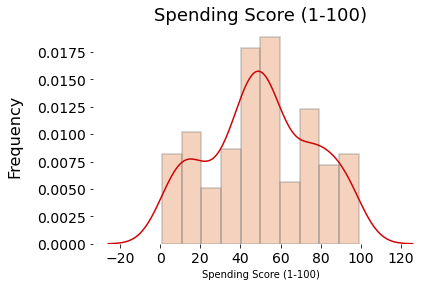

In [17]:
graph_histo(spending)

Then, we'll check **Age**.

In [18]:
age = customers["Age"]

In [19]:
statistics(age)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Age,38.85,13.934041,36.0,194.1575


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



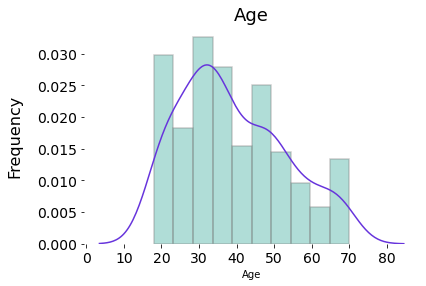

In [20]:
graph_histo(age)

Finally, we'll explore **Annual Income** variable.

In [21]:
income = customers["Annual Income (k$)"]

In [22]:
statistics(income)

,Mean,Standard Deviation,Median,Variance
Variable,,,,
Annual Income (k$),60.56,26.198977,61.5,686.3864


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



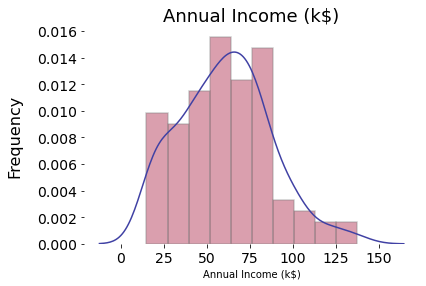

In [23]:
graph_histo(income)

In [24]:
gender = customers["Gender"]

In [25]:
statistics(gender)

,Gender
Female,112
Male,88


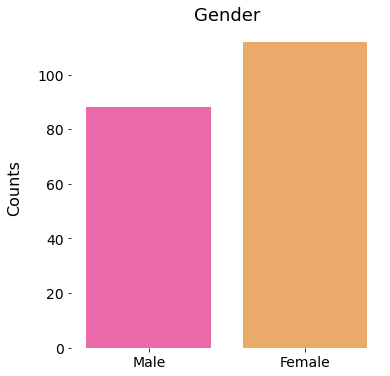

In [26]:
graph_histo(gender)

#### Correlation between parameteres

Also, we will analyze the correlation between the numeric parameters. For that aim, we'll use the `pairplot` seaborn function. We want to see whether there is a difference between gender. So, we are going to set the `hue` parameter to get different colors for points belonging to female or customers.

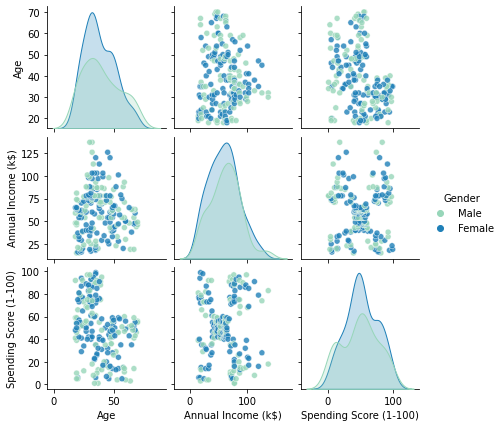

In [27]:
sns.pairplot(customers, x_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               y_vars = ["Age", "Annual Income (k$)", "Spending Score (1-100)"], 
               hue = "Gender", 
               kind= "scatter",
               palette = "YlGnBu",
               height = 2,
               plot_kws={"s": 35, "alpha": 0.8});

#### Why is it important to look into the descriptive statistics, distribution and correlation between variables?

In order to apply K-means, we need to meet the algorithm assumptions. 
  
K-means assumes:

- **Cluster's shape**: The variance of the distribution is spherical meaning that clusters have a spherical shape. In order for this to be true, all variables should be normally distributed and have the same variance.
- **Clusters' Size**: All clusters have the same number of observations.
- **Relationship between variables**: There is little or no correlation between the variables.

In our dataset, our variables are normally distributed. Variances are quite close to each other. Except for age that has a lower variance that the rest of the variables.
We could find a proper transformation to solve this issue. We could apply the logarithm or Box-Cox transformation. 
Box-Cox is a family of transformations which allows us to correct non-normal distributed variables or non-equal variances.

### Dimensionality reduction

After we checked that we can apply k-means, we can apply Principal Component Analysis (PCA) to discover which dimensions best maximize the variance of features involved.

#### Principal Component Analysis (PCA)

First, we'll transform the categorical variable into two binary variables.

In [28]:
customers["Male"] = customers.Gender.apply(lambda x: 0 if x == "Male" else 1)

In [29]:
customers["Female"] = customers.Gender.apply(lambda x: 0 if x == "Female" else 1)

Then, we are going to select from the dataset all the useful columns. Customer ID is not a useful feature. Gender will split it into two binaries categories. It should not appear in the final dataset

In [30]:
X = customers.iloc[:, 2:]

In [31]:
X.head()

,Age,Annual Income (k$),Spending Score (1-100),Male,Female
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


In order to apply PCA, we are going to use the `PCA` function from sklearn module.

In [32]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)

During the fitting process, the model learns some quantities from the data: the "components" and "explained variance".

In [33]:
print(pca.components_)

[[-1.88980385e-01  5.88604475e-01  7.86022241e-01  3.32880772e-04
  -3.32880772e-04]
 [ 1.30957602e-01  8.08400899e-01 -5.73875514e-01 -1.57927017e-03
   1.57927017e-03]]


In [34]:
print(pca.explained_variance_)

[700.26450987 684.33354753]


These numbers that appear to be abstract define vectors. The components define the direction of the vector while the explained variance define the squared-length of the vector.

The vectors represent the principal axes of the data. The length of the vector indicates the importance of that axis in describing the distribution of the data. The projection of each data point onto the principal axes are the principal components of the data.

In [35]:
# Transform samples using the PCA fit
pca_2d = pca.transform(X)

We can represent this using a type of scatter plot called biplot. Each point is represented by its score regarding the principal components.
It is helpful to understand the reduced dimensions of the data. It also helps us discover relationships between the principal components and the original variables.

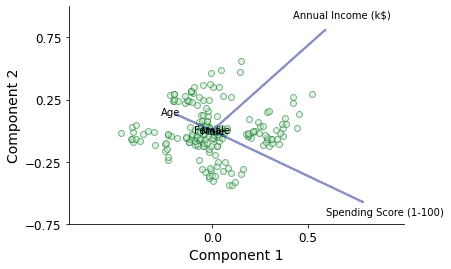

In [36]:
extra_graphs.biplot(pca_2d[:,0:2], np.transpose(pca.components_[0:2, :]), labels=X.columns)

We can observe that Annual Income as well as Spending Score at the two most important components.

### K-means clustering 

The Elbow method looks at how the total WSS varies with the number of clusters. 
For that, we'll compute k-means for a range of different values of k. Then, we calculate the total WSS. We plot the curve WSS vs. number of clusters. 
Finally, we locate the elbow or bend of the plot. This point is considered to be the appropriate number of clusters.

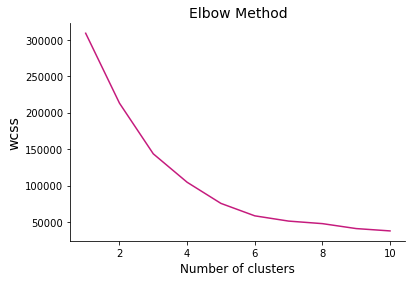

In [37]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show() 

How does k-means clustering works? The main idea is to select k centers, one for each cluster. There are several ways to initialize those centers. We can do it randomly, pass certain points that we believe are the center or place them in a smart way (e.g. as far away from each other as possible).
Then, we calculate the Euclidean distance between each point and the cluster centers. We assign the points to the cluster center where the distance is minimum.
After that, we recalculate the new cluster center. We select the point that is in the middle of each cluster as the new center. 
And we start again, calculate distance, assign to cluster, calculate new centers. When do we stop? When the centers do not move anymore.

In [38]:
# Kmeans algorithm
# n_clusters: Number of clusters. In our case 5
# init: k-means++. Smart initialization
# max_iter: Maximum number of iterations of the k-means algorithm for a single run
# n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
# random_state: Determines random number generation for centroid initialization.
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

# Fit and predict 
y_means = kmeans.fit_predict(X)

Now, let's check how our clusters look like:

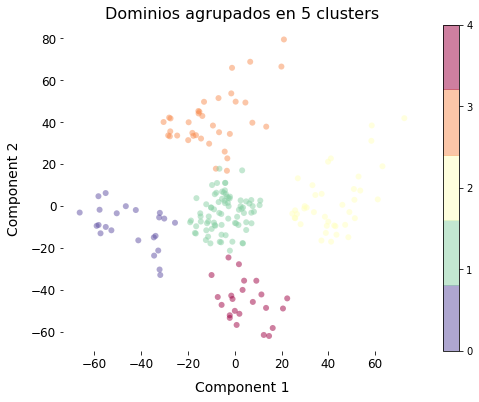

In [39]:
fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 5),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Dominios agrupados en 5 clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4]);

plt.show()

In [40]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ["Age", "Annual Income", "Spending", "Male", "Female"])

In [41]:
centroids.index_name = "ClusterID"

In [42]:
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)

In [43]:
centroids

,Age,Annual Income,Spending,Male,Female,ClusterID
0,45.217391,26.304348,20.913043,0.608696,0.391304,0
1,43.088608,55.291139,49.569620,0.582278,0.417722,1
2,32.692308,86.538462,82.128205,0.538462,0.461538,2
3,40.666667,87.750000,17.583333,0.472222,0.527778,3
4,25.521739,26.304348,78.565217,0.608696,0.391304,4


The most important features appear to be Annual Income and Spending score. 
We have people whose income is low but spend in the same range - segment 0. 

People whose earnings a high and spend a lot - segment 1. 

Customers whose income is middle range but also spend at the same level - segment 2. 

Then we have customers whose income is very high but they have most spendings - segment 4.

And last, people whose earnings are little but they spend a lot- segment 5.

Imagine that tomorrow we have a new member. And we want to know which segment that person belongs. We can predict this.

In [44]:
X_new = np.array([[43, 76, 56, 0, 1]]) 
 
new_customer = kmeans.predict(X_new)
print(f"The new customer belongs to segment {new_customer[0]}")

The new customer belongs to segment 1
